# Visualize Signal

## Introduction

Example notebook. Visualize a signal.   


## Setup

In [1]:
ticker = '^IXIC'
label = "SDS_standard"
from_date = "2000-01-01"
out_dir = r"./out_market_indicator_visualize"

In [2]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib widget
# inline is the old interface

## Load Data

In [3]:
ohlcv = pd.read_csv(os.path.join(r'../md/daily', '^IXIC_1990.csv'))
ohlcv = ohlcv[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

## Signal

Example signal. 

Signal is based on price, a short MA and a long MA. 

Matrix of six states: 
ShortMA above LongMA: Price > Short: +1; Price between Short and Long: 0; Price below Short and Long: -1. 
ShortMA below LongMA: Price > Long: 1; Price between Short and Long: 0; Price below Short: -1. 

In [5]:
class MACrossover3(Signal):
    # Signal interface: 
    # Signal has a name. 
    # Signal acts on a dataframe with columns DOHLCV. Date is a datetime column, the others float columns. 
    # Evaluating signal returns a df with the same dimentions (and index) as DOHLCV, with columns val (float -1..1)and id (integer). 
    # Potentially more helper/intermediate variables, with names with leading underscores. 
    def __init__(self, name, shortMA=50, longMA=150): 
        self.SHORT_MA = shortMA
        self.LONG_MA = longMA

    def __call__(self, ohlcv):
        t = ohlcv.copy()
        t['shortMA'] = 
        
        
        t['ret'] = (t.Close / t.Close.shift()) - 1
        t['volume_ret'] = (t.Volume / t.Volume.shift()) - 1
        t['adv'] = t.Volume.rolling(self.ADV_DAY_COUNT).mean()
        t['vol_vs_adv'] = t.Volume / t.adv

        # distribution days
        t['is_sell_day'] = (t.ret < self.SELL_DAY_RETURN) & (t.volume_ret > self.SELL_DAY_VOL_RETURN)
        t['sell_day_count'] = 0

        # market state transitions
        t['MARKET_STATE'] = np.NaN  # 1: uptrend, -1: correction
        t['rally_day_count'] = 0
        t['rally_day_close'] = np.NaN
        t['FTD'] = False
        for ndx, row in t.iterrows():
            MARKET_STATE = t.columns.get_loc('MARKET_STATE')

            if ndx == 273:
                print("breakpoint")

            if ndx < self.SELL_DAY_WINDOW_LENGTH:
                t.iloc[ndx, MARKET_STATE] = 1
                continue

            if t.iloc[ndx - 1, MARKET_STATE] == 1:
                # update sell day count
                sell_day_count = 0
                for i in range(self.SELL_DAY_WINDOW_LENGTH):
                    w = ndx - i
                    r = t.iloc[ndx, t.columns.get_loc('Close')]/t.iloc[ndx-i, t.columns.get_loc('Close')] - 1
                    isd = t.iloc[ndx-i, t.columns.get_loc('is_sell_day')]
                    if isd and r <= self.SELL_DAY_CANCEL_RETURN:
                        sell_day_count = sell_day_count + 1
                t.iloc[ndx, t.columns.get_loc('sell_day_count')] = sell_day_count
                if sell_day_count >= self.SELL_DAY_COUNT_THRESHOLD:
                    t.iloc[ndx, MARKET_STATE] = -1  # to market in correction
                else:
                    t.iloc[ndx, MARKET_STATE] = t.iloc[ndx - 1, MARKET_STATE]  # stay in uptrend
                continue

            if (t.iloc[ndx - 1, MARKET_STATE] == -1):  # in correction
                if t.iloc[ndx-1, t.columns.get_loc('rally_day_count')] == 0:
                    if t.iloc[ndx, t.columns.get_loc('ret')] > 0:
                        t.iloc[ndx, t.columns.get_loc('rally_day_count')] = 1
                        t.iloc[ndx, t.columns.get_loc('rally_day_close')] = t.iloc[ndx, t.columns.get_loc('Close')]
                    t.iloc[ndx, MARKET_STATE] = t.iloc[ndx - 1, MARKET_STATE]
                else:  # we are in a rally
                    if t.iloc[ndx, t.columns.get_loc('Close')] < t.iloc[ndx - 1, t.columns.get_loc('rally_day_close')]:
                        t.iloc[ndx, t.columns.get_loc('rally_day_count')] = 0
                        t.iloc[ndx, MARKET_STATE] = t.iloc[ndx - 1, MARKET_STATE]
                    elif t.iloc[ndx - 1, t.columns.get_loc('rally_day_count')] >= self.FTD_MAX_DIST:
                        t.iloc[ndx, t.columns.get_loc('rally_day_count')] = 0
                        t.iloc[ndx, MARKET_STATE] = t.iloc[ndx - 1, MARKET_STATE]
                    elif ((t.iloc[ndx, t.columns.get_loc('ret')] > self.FTD_RETURN) and
                          (t.iloc[ndx, t.columns.get_loc('volume_ret')] > self.FTD_VOL_RETURN) and
                          (t.iloc[ndx, t.columns.get_loc('Volume')] > t.iloc[ndx, t.columns.get_loc('adv')]) and
                          (t.iloc[ndx-1, t.columns.get_loc('rally_day_count')] >= self.FTD_MIN_DIST-1)):
                        t.iloc[ndx, t.columns.get_loc('FTD')] = True
                        t.iloc[ndx, MARKET_STATE] = 1  # to uptrend
                    else:
                        t.iloc[ndx, t.columns.get_loc('rally_day_count')] = t.iloc[ndx - 1, t.columns.get_loc(
                            'rally_day_count')] + 1
                        t.iloc[ndx, t.columns.get_loc('rally_day_close')] = t.iloc[
                            ndx - 1, t.columns.get_loc('rally_day_close')]
                        t.iloc[ndx, MARKET_STATE] = t.iloc[ndx - 1, MARKET_STATE]
                continue

            print(f"Should never get here: {ndx}!")

        return t

In [5]:
mi = WONMarketIndicator()
rv = mi(ohlcv)

breakpoint


In [6]:
rv.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ret', 'volume_ret',
       'adv', 'vol_vs_adv', 'is_sell_day', 'sell_day_count', 'MARKET_STATE',
       'rally_day_count', 'rally_day_close', 'FTD'],
      dtype='object')

In [7]:
w = rv[['Date', 'Close', 'Volume', 'ret', 'volume_ret', 'adv', 'vol_vs_adv', 'is_sell_day', 'sell_day_count','MARKET_STATE', 'rally_day_count', 'rally_day_close', 'FTD']]
w.iloc[7220:7250,:]

,Date,Close,Volume,ret,volume_ret,adv,vol_vs_adv,is_sell_day,sell_day_count,MARKET_STATE,rally_day_count,rally_day_close,FTD
7220,2018-08-27,"8,017.90",2319130000,0.01,0.23,"2,016,163,500.00",1.15,False,0,-1.00,7,"7,816.33",False
7221,2018-08-28,"8,030.04",1961300000,0.00,-0.15,"2,004,476,000.00",0.98,False,0,-1.00,8,"7,816.33",False
7222,2018-08-29,"8,109.69",1897000000,0.01,-0.03,"1,988,148,500.00",0.95,False,0,-1.00,9,"7,816.33",False
7223,2018-08-30,"8,088.36",2014450000,-0.00,0.06,"1,984,806,000.00",1.01,True,0,-1.00,10,"7,816.33",False
7224,2018-08-31,"8,109.54",1899910000,0.00,-0.06,"1,978,866,500.00",0.96,False,0,-1.00,11,"7,816.33",False
7225,2018-09-04,"8,091.25",2229520000,-0.00,0.17,"1,978,434,000.00",1.13,True,0,-1.00,12,"7,816.33",False
7226,2018-09-05,"7,995.17",2596780000,-0.01,0.16,"1,998,393,500.00",1.30,True,0,-1.00,0,NaN,False
7227,2018-09-06,"7,922.73",2368680000,-0.01,-0.09,"2,012,435,000.00",1.18,False,0,-1.00,0,NaN,False
7228,2018-09-07,"7,902.54",2146380000,-0.00,-0.09,"2,018,106,500.00",1.06,False,0,-1.00,0,NaN,False
7229,2018-09-10,"7,924.16",2041450000,0.00,-0.05,"2,015,420,000.00",1.01,False,0,-1.00,1,"7,924.16",False


In [9]:
w.to_csv('debug_wonmi.csv')

### Visualize signals

In [14]:
md = rv[['Date', 'Open', 'High', 'Low', 'Close', 'MARKET_STATE','sell_day_count', 'rally_day_count', 'ret', 'volume_ret', 'vol_vs_adv']]
md['Date'] = pd.to_datetime(md.Date)
md.set_index('Date', inplace=True, drop=True) 

C:\Users\JanMarek\AppData\Local\Temp\ipykernel_5324\188979383.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
#df = pd.read_csv(os.path.join(out_dir, f"pos_{ticker}_{label}.csv"),index_col=0,parse_dates=True)
md['50dSMA'] = md.Close.rolling(50, min_periods=20).mean()
md['200dSMA'] = md.Close.rolling(200,min_periods=100).mean()

C:\Users\JanMarek\AppData\Local\Temp\ipykernel_5324\4291020555.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JanMarek\AppData\Local\Temp\ipykernel_5324\4291020555.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
md = md.loc['2018-05-01':'2019-02-01']

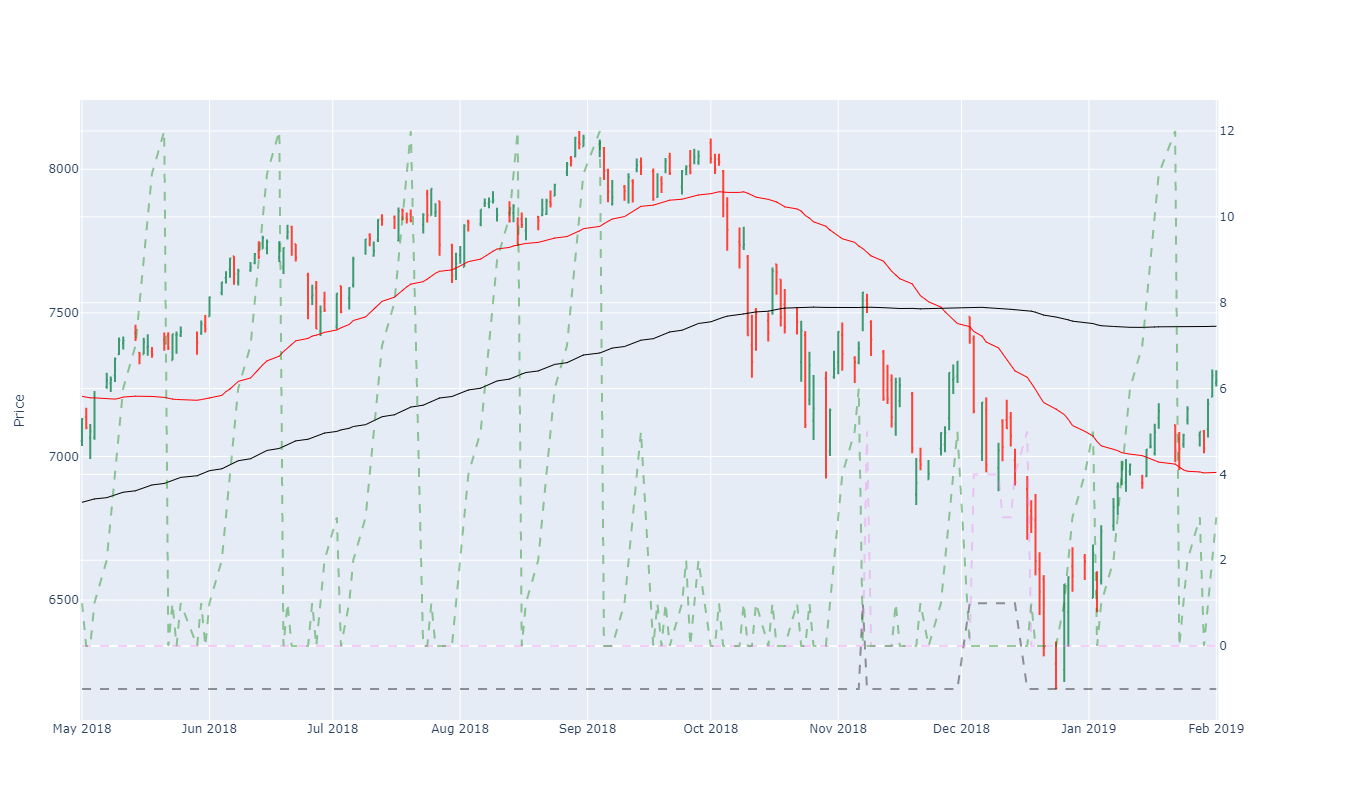

In [17]:
fig = make_subplots(specs=[[{"secondary_y":True}]])

fig.add_trace(go.Ohlc(
    name="price",
    x=md.index, open=md.Open, high=md.High, low=md.Low, close=md.Close,
    xhoverformat='%Y-%m-%d'),secondary_y = False)
fig.add_trace(go.Scatter(name="ma50",x=md.index,y=md["50dSMA"],line={'color': 'red', 'width': 1}),secondary_y=False)
fig.add_trace(go.Scatter(name="ma200",x=md.index,y=md["200dSMA"],line={'color': 'black', 'width': 1}),secondary_y=False)

fig.add_trace(go.Scatter(name='WON_MI',x = md.index,y = md.MARKET_STATE,line_color='black',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
              secondary_y = True)
fig.add_trace(go.Scatter(name='DD_COUNT',x = md.index,y = md.sell_day_count,line_color='violet',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
              secondary_y = True)
fig.add_trace(go.Scatter(name='RALLY',x = md.index,y = md.rally_day_count,line_color='green',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
              secondary_y = True)
fig.add_trace(go.Scatter(name='RET',x = md.index,y = md.ret,line_color='violet',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.01),
              secondary_y = True)
fig.add_trace(go.Scatter(name='VOL_RET',x = md.index,y = md.volume_ret,line_color='violet',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.01),
              secondary_y = True)
fig.add_trace(go.Scatter(name='VOL_VS_ADV',x = md.index,y = md.vol_vs_adv,line_color='violet',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.01),
              secondary_y = True)

# fig.add_trace(go.Scatter(name=entry_signal.name,x=df.index,y=df.es,line_color='cyan',mode='lines',line={'dash':'dash'},marker_line_width=1,opacity=0.4),
#               secondary_y = False)

fig.update_layout(autosize=False, 
                  width=1500,
                  height=800,
                  title="",
                  yaxis_title="Price",
                  xaxis_rangeslider_visible=False,
                  showlegend=False,
                 hovermode='x unified')
fig.show()